In [163]:
import os
import sys
sys.path.append('../kl_tools/')
import numpy as np
from astropy.units import Unit
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.axes3d import get_test_data
import galsim as gs
import galsim.roman as roman
from galsim.angle import Angle, radians
import pickle
import basis
import cube
import intensity
import likelihood
import mcmc
import parameters
from parameters import Pars
import priors
import utils
import velocity
from DataSimulator import DataSimulator
from likelihood import LogLikelihood_Roman, LogPosterior_Roman
import getdist
from getdist import plots, MCSamples
# new modules
from spectrum import Spectrum
#from MockObs import Mock
%matplotlib inline

In [152]:
datadir = "../tests/test-mcmc-run/hst_g141_noisefree_AEGIS19843-like_longer"
with open(datadir+'/test-mcmc-runner.pkl', 'rb') as f:
    runner = pickle.load(f)
with open(datadir+'/test-mcmc-sampler.pkl', 'rb') as f:
    sampler = pickle.load(f)
with open(datadir+'/test-mcmc-truth.pkl', 'rb') as f:
    truth = pickle.load(f)
with open(datadir+'/chain-probabilities.pkl', 'rb') as f:
    chain_prob = pickle.load(f)
pars_from_yaml = Pars(yaml_file=datadir+"/params_HST.yaml")

#like_from_yaml = LogLikelihood_Roman(pars_from_yaml, fid_pars=pars_from_yaml.sampled_fid)
logprob = LogPosterior_Roman(pars_from_yaml, 
        fid_pars=pars_from_yaml.sampled_fid)
data_fid, covs_fid = logprob.log_likelihood.dsim.evaluateSimulatedData(pars_from_yaml.sampled_fid, 
                                                               force_noise_free = False)

Reading parameter settings from YAML file (<class '_io.TextIOWrapper'>)
{'sampled_pars': {'g1': {'fid': 0.0, 'min': -1.0, 'max': 1.0, 'order': 1}, 'g2': {'fid': 0.0, 'min': -1.0, 'max': 1.0, 'order': 2}, 'theta_int': {'fid': 0.0, 'min': -1.5708, 'max': 1.5708, 'order': 3}, 'sini': {'fid': 0.5, 'min': -1.0, 'max': 1.0, 'order': 4}, 'v0': {'fid': 0.0, 'mean': 0.0, 'std': 20.0, 'clip_sigmas': 10.0, 'order': 5}, 'vcirc': {'fid': 200.0, 'mean': 200.0, 'std': 10.0, 'clip_sigmas': 10.0, 'order': 6}, 'rscale': {'fid': 0.5, 'min': 0.0, 'max': 2.0, 'order': 7}}, 'model_dimension': {'Nx': 48, 'Ny': 48, 'scale': 0.1, 'lambda_range': [1190.0, 1370.0], 'lambda_res': 4, 'lambda_unit': 'nm'}, 'intensity': {'type': 'inclined_exp', 'hlr': 0.5}, 'velocity': {'model_name': 'default', 'v_unit': 'km / s', 'r_unit': 'arcsec'}, 'sed': {'template': '../data/Simulation/GSB2.spec', 'wave_type': 'Ang', 'flux_type': 'flambda', 'z': 0.9513, 'wave_range': [500.0, 3000.0], 'obs_cont_norm': [614, 3.9e-17], 'lines': {'

In [71]:
chains = sampler.get_chain(flat=False)
print(chains.shape)
blobs = sampler.get_blobs(flat=False)
print(blobs.shape)
chains_with_blobs = np.concatenate([chains, blobs], axis=2)
print(chains_with_blobs.shape)
### check sini branch
posi_sini = []
nega_sini = []
for i in range(14):
    size = np.where(chains[:,i,3]<0)[0].shape[0]
    print(size)
    if size>10000:
        nega_sini.append(i)
    else:
        posi_sini.append(i)
print(f'Positive sini chains: {posi_sini}, negative sini chains: {nega_sini}')

(40000, 14, 7)
(40000, 14, 5)
(40000, 14, 12)
39997
39995
1
3
7
0
40000
0
40000
2
4
0
0
40000
Positive sini chains: [2, 3, 4, 5, 7, 9, 10, 11, 12], negative sini chains: [0, 1, 6, 8, 13]


In [72]:
names = ['g1', 'g2', 'theta_int', 'sini', 'v0', 'vcirc', 'hlr']
names_with_blobs = names + ['prior', 'post', 'like_1', 'like_2', 'like_3']
labels= [r'g_1', r'g_2', r'\theta_{int}', r'sin(i)', r'v_0', r'v_{circ}', r'r_{hlr}']
labels_with_blobs = labels + ['prior', 'post', 'like_1', 'like_2', 'like_3']

mks = {}
for k,v in zip(names, truth):
    mks[k]=v
print(mks)

{'g1': 0.0, 'g2': 0.0, 'theta_int': 0.0, 'sini': 0.5, 'v0': 0.0, 'vcirc': 200.0, 'hlr': 0.5}


In [117]:
sample_total = getdist.mcsamples.MCSamples(samples=[chains[:,i,:] for i in range(chains.shape[1])], 
                                           names=names, labels=labels, label='all',
                                          loglikes=[blobs[:,i,1] for i in range(blobs.shape[1])])
#sample_1 = getdist.mcsamples.MCSamples(samples=[chains[:,i,:] for i in range(chains.shape[1])], 
#                                           names=names, labels=labels,
#                                          loglikes=[blobs[:,i,2] for i in range(blobs.shape[1])])
#sample_2 = getdist.mcsamples.MCSamples(samples=[chains[:,i,:] for i in range(chains.shape[1])], 
#                                           names=names, labels=labels,
#                                          loglikes=[blobs[:,i,3] for i in range(blobs.shape[1])])
#sample_3 = getdist.mcsamples.MCSamples(samples=[chains[:,i,:] for i in range(chains.shape[1])], 
#                                           names=names, labels=labels,
#                                          loglikes=[blobs[:,i,4] for i in range(blobs.shape[1])])
sample_posi_sini = getdist.mcsamples.MCSamples(
    samples = [chains[:,i,:] for i in posi_sini],
    names=names, labels=labels, label='posi sini')
_params = sample_posi_sini.getParams()
sample_posi_sini.addDerived(
    paramVec=np.sqrt(_params.g1**2+_params.g2**2), 
    name='g', label='g')
sample_posi_sini.addDerived(
    paramVec=np.arctan2(_params.g2, _params.g1)/2.,
    name='beta', label='beta')

sample_nega_sini = getdist.mcsamples.MCSamples(
    samples = [chains[:,i,:] for i in nega_sini],
    names=names, labels=labels, label='nega sini')
sample_posi_sini_blobs = getdist.mcsamples.MCSamples(
    samples = [chains_with_blobs[:,i,:] for i in posi_sini],
    names=names_with_blobs, labels=labels_with_blobs, label='posi sini')
sample_nega_sini_blobs = getdist.mcsamples.MCSamples(
    samples = [chains_with_blobs[:,i,:] for i in nega_sini],
    names=names_with_blobs, labels=labels_with_blobs, label='nega sini')

#sample_fid = getdist.mcsamples.MCSamples(samples = np.array([truth,]*1000), 
#                                         names=names, labels=labels, label='fid')
#sample_fid.addDerived(paramVec=[0.], name='post',label='post')
#sample_fid.addDerived(paramVec=[0.], name='like_1',label='like_1')
#sample_fid.addDerived(paramVec=[0.], name='like_2',label='like_2')
#sample_fid.addDerived(paramVec=[0.], name='like_3',label='like_3')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [116]:
names

['g1', 'g2', 'theta_int', 'sini', 'v0', 'vcirc', 'hlr']

In [113]:
chains.shape

(40000, 14, 7)

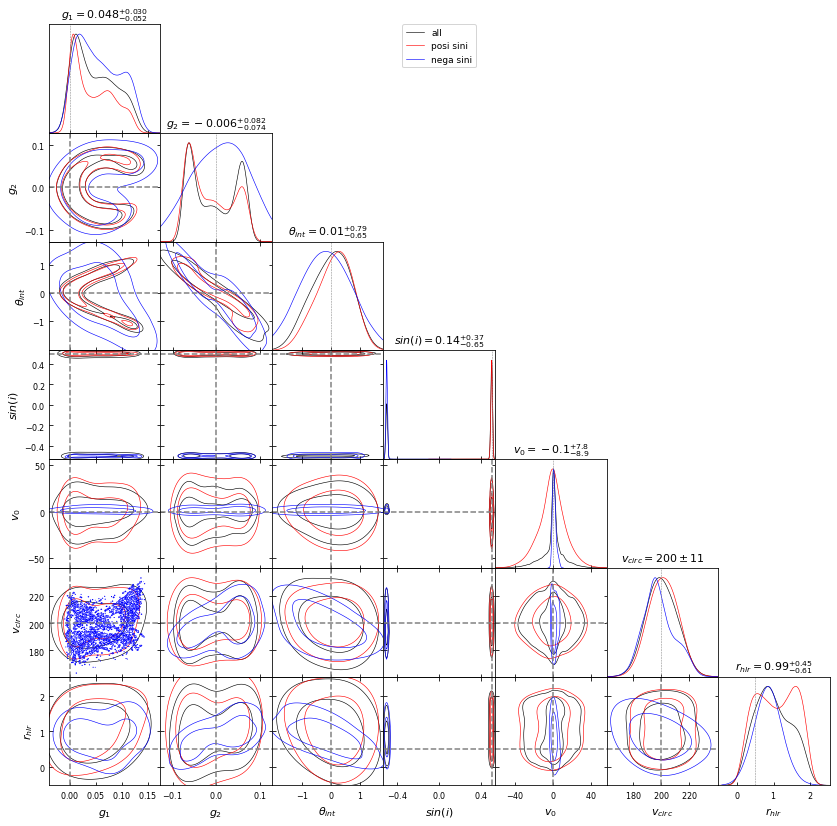

In [95]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 14
g.triangle_plot(
    [sample_total,sample_posi_sini, sample_nega_sini], 
    filled=False, title_limit=1,
    markers=mks, marker_args={'lw':1.5,'ls':'--'},
    
)

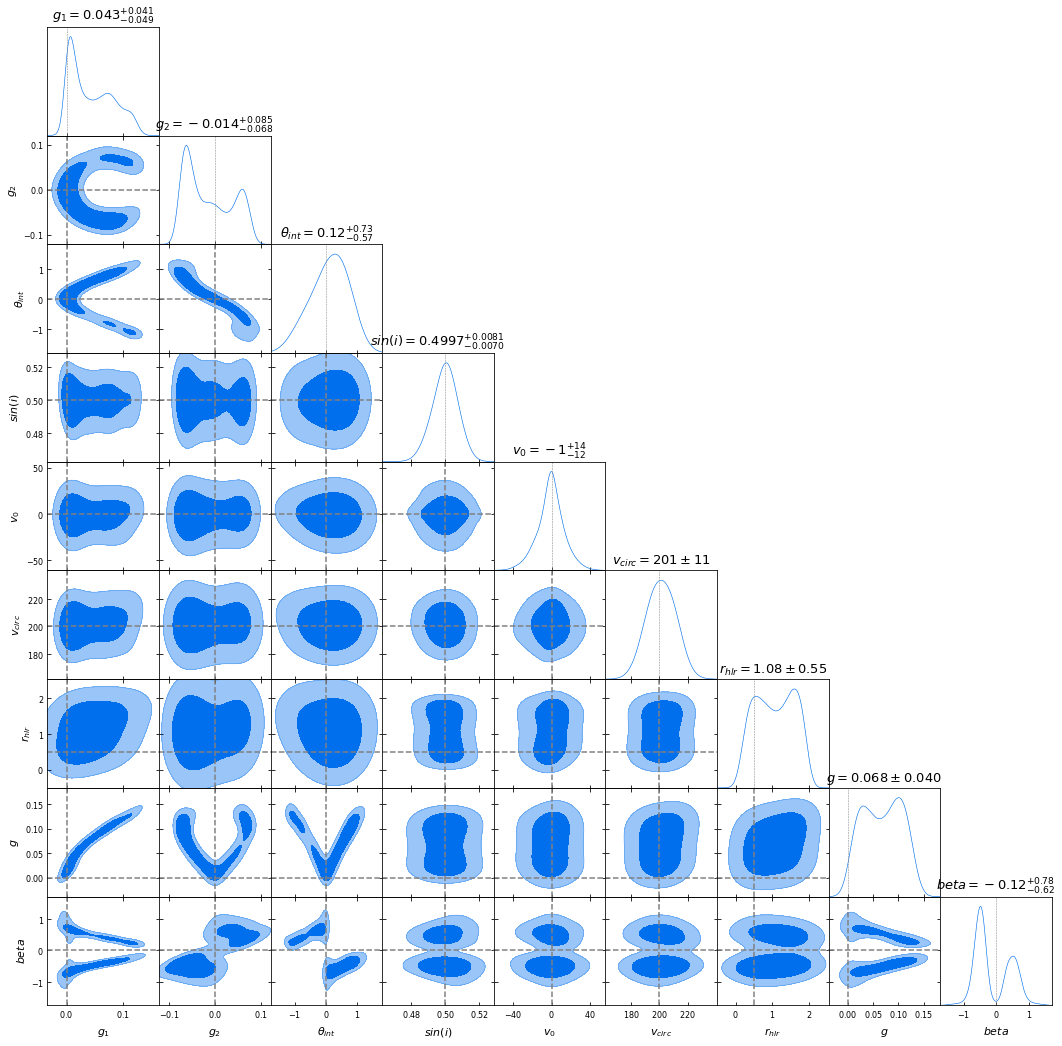

In [96]:
g = plots.get_subplot_plotter()
mks_derived = mks.copy()
mks_derived['g'] = np.sqrt(mks_derived['g1']**2 + mks_derived['g2']**2)
mks_derived['beta'] = np.arctan2(mks_derived['g2'], mks_derived['g1'])
g.settings.title_limit_fontsize = 16
g.triangle_plot(
    [sample_posi_sini, ], 
    filled=True, title_limit=1,
    markers=mks_derived, marker_args={'lw':1.5,'ls':'--'},
    
)

In [67]:
max_logpost_posi_sini = np.max([blobs[:,i,1] for i in posi_sini])
max_logpost_nega_sini = np.max([blobs[:,i,1] for i in nega_sini])
print(max_logpost_posi_sini, max_logpost_nega_sini)

-0.03875498843568502 -0.6467288756248922


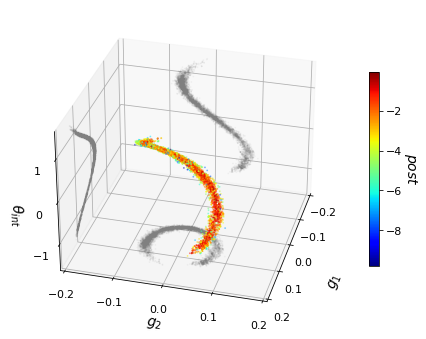

In [252]:
g = plots.get_single_plotter()
g.plot_4d([sample_posi_sini_blobs,],
          ['g1', 'g2', 'theta_int', 'post'], 
          cmap='jet',
          alpha=0.4, shadow_alpha=0.05, shadow_color=True,
          max_scatter_points=6000,
          lims={'g1': (-0.2, 0.2), 'g2': (-0.2, 0.2), 'theta_int': (-np.pi/2, np.pi/2), 
                'post':(-10,0),
                #'like_1':(-1,0),
                #'like_2':(-1,0),
                #'like_3':(-1,0),
               },
          colorbar_args={'shrink': 0.6},
          marker=['.','o'])
ax = plt.gca()
ax.scatter([0,], [0,], [0,], s=10, marker='*', )

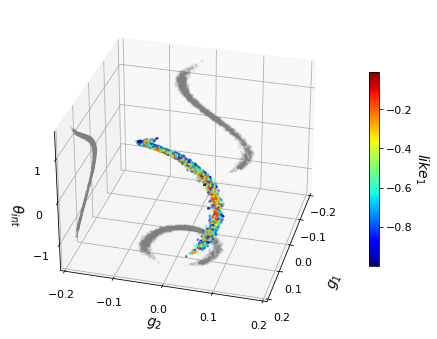

In [83]:
g = plots.get_single_plotter()
g.plot_4d(sample_posi_sini_blobs, ['g1', 'g2', 'theta_int', 'like_1'], cmap='jet',
          alpha=0.4, shadow_alpha=0.05, shadow_color=True,
          max_scatter_points=6000,
          lims={'g1': (-0.2, 0.2), 'g2': (-0.2, 0.2), 'theta_int': (-np.pi/2, np.pi/2), 
                #'post':(-1,0),
                'like_1':(-1,0),
                #'like_2':(-1,0),
                #'like_3':(-1,0),
               },
          colorbar_args={'shrink': 0.6})

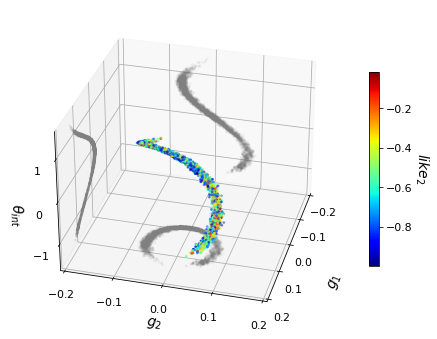

In [84]:
g = plots.get_single_plotter()
g.plot_4d(sample_posi_sini_blobs, ['g1', 'g2', 'theta_int', 'like_2'], cmap='jet',
          alpha=0.4, shadow_alpha=0.05, shadow_color=True,
          max_scatter_points=6000,
          lims={'g1': (-0.2, 0.2), 'g2': (-0.2, 0.2), 'theta_int': (-np.pi/2, np.pi/2), 
                #'post':(-1,0),
                #'like_1':(-1,0),
                'like_2':(-1,0),
                #'like_3':(-1,0),
               },
          colorbar_args={'shrink': 0.6})

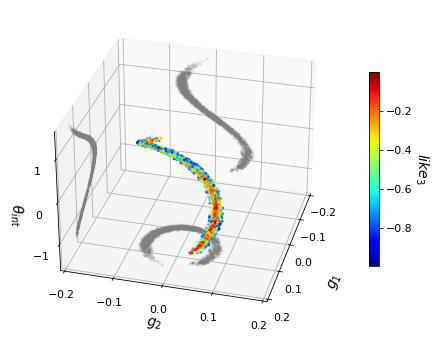

In [85]:
g = plots.get_single_plotter()
g.plot_4d(sample_posi_sini_blobs, ['g1', 'g2', 'theta_int', 'like_3'], cmap='jet',
          alpha=0.4, shadow_alpha=0.05, shadow_color=True,
          max_scatter_points=6000,
          lims={'g1': (-0.2, 0.2), 'g2': (-0.2, 0.2), 'theta_int': (-np.pi/2, np.pi/2), 
                #'post':(-1,0),
                #'like_1':(-1,0),
                #'like_2':(-1,0),
                'like_3':(-1,0),
               },
          colorbar_args={'shrink': 0.6})

## Sort posterior and see how data vector changes

In [240]:
Ntests = 300
_params = sample_posi_sini_blobs.getParams()
index = np.argsort(_params.post)[-Ntests:]
#index_2 = np.argsort(_params.theta_int[index])
params_tests = np.zeros((Ntests, 8))
for i in range(Ntests):
    params_tests[i,0] = _params.g1[index[i]]
    params_tests[i,1] = _params.g2[index[i]]
    params_tests[i,2] = _params.theta_int[index[i]]
    params_tests[i,3] = _params.sini[index[i]]
    params_tests[i,4] = _params.v0[index[i]]
    params_tests[i,5] = _params.vcirc[index[i]]
    params_tests[i,6] = _params.hlr[index[i]]
    params_tests[i,7] = _params.post[index[i]]

In [241]:
params_tests[130]

array([ 6.48278688e-04, -7.04855791e-03,  6.03806992e-02,  5.00389815e-01,
        2.99346824e+00,  2.10354247e+02,  1.06294204e+00, -1.16811260e-01])

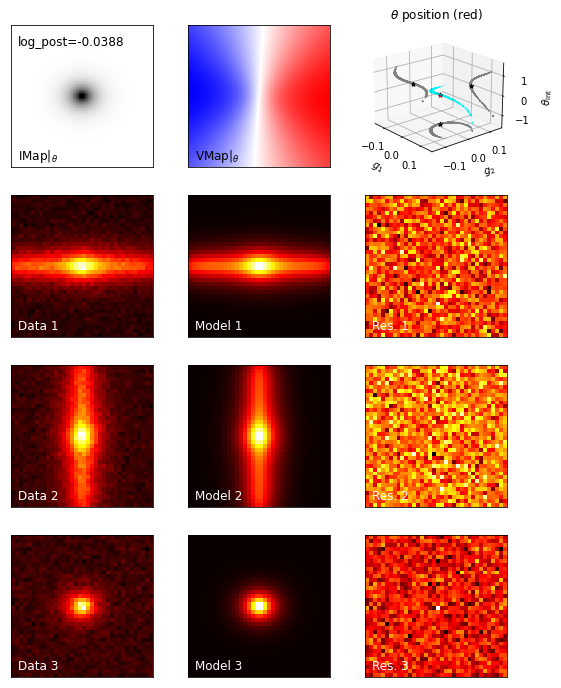

In [248]:
i = 299
### ======================================================
#fig, axes = plt.subplots(4,3,figsize=(9,12))
fig = plt.figure(figsize=(9,12))

par_now = params_tests[i]
data_now, covs_now = logprob.log_likelihood.dsim.evaluateSimulatedData(par_now[:-1], 
                                                               force_noise_free = True)
params = sample_posi_sini_blobs.getParams()
idx = np.where(params.post>-0.5)[0]

# panel 1-1: true intensity map
ax = fig.add_subplot(4, 3, 1)
ax.imshow(logprob.log_likelihood.dsim.imap_img, origin='lower', cmap='binary')
ax.text(0.05,0.05,r"IMap$|_{\theta}$", transform=ax.transAxes, color='k', fontsize=12)
ax.text(0.05,0.85,"log_post=%.4f"%par_now[-1], transform=ax.transAxes, color='k', fontsize=12)
ax.set(xticks=[], yticks=[])

# panel 1-2: true velocity map
ax = fig.add_subplot(4, 3, 2)
ax.imshow(logprob.log_likelihood.dsim.vmap_img, origin='lower', cmap='bwr')
ax.text(0.05,0.05,r"VMap$|_{\theta}$", transform=ax.transAxes, color='k', fontsize=12)
ax.set(xticks=[], yticks=[])

# panel 1-3:
ax = fig.add_subplot(4, 3, 3, projection='3d')
ax.view_init(20, -40)

ax.scatter(params.g1[idx], params.g2[idx], params.theta_int[idx], 
           s=1, marker='.', alpha=0.01, color='cyan')
ax.scatter(params.g1[idx], params.theta_int[idx], 
           s=1, color='grey', marker='.', zdir='y', zs=0.15, alpha=0.01, zorder=0)
ax.scatter(params.g2[idx], params.theta_int[idx], 
           s=1, color='grey', marker='.', zdir='x', zs=-0.15, alpha=0.01, zorder=0)
ax.scatter(params.g1[idx], params.g2[idx],
           s=1, color='grey', marker='.', zdir='z', zs=-np.pi/2, alpha=0.01, zorder=0)
# parameter now
ax.scatter(par_now[0], par_now[1], par_now[2], 
           s=20, marker='*', color='r')
ax.scatter(par_now[0], par_now[2],
           s=20, color='k', marker='*', zdir='y', zs=0.15, zorder=2)
ax.scatter(par_now[1], par_now[2],
           s=20, color='k', marker='*', zdir='x', zs=-0.15, zorder=2)
ax.scatter(par_now[0], par_now[1],
           s=20, color='k', marker='*', zdir='z', zs=-np.pi/2, zorder=2)

ax.set_xlim([-0.15, 0.15])
ax.set_ylim([-0.15, 0.15])
ax.set_zlim([-np.pi/2, np.pi/2])
ax.set_xlabel(r'$g_1$')
ax.set_ylabel(r'$g_2$')
ax.set_zlabel(r'$\theta_{\mathrm{int}}$')
ax.set_title(r'$\theta$ position (red)')

# panel 2-1
ax = fig.add_subplot(4,3,4)
ax.imshow(data_fid[0] + covs_fid[0], 
          origin='lower', cmap='hot')
ax.text(0.05,0.05,r"Data 1", transform=ax.transAxes, color='white', fontsize=12)
ax.set(xticks=[], yticks=[])

# panel 2-2
ax = fig.add_subplot(4,3,5)
ax.imshow(data_now[0], origin='lower', cmap='hot')
ax.text(0.05,0.05,r"Model 1", transform=ax.transAxes, color='white', fontsize=12)
ax.set(xticks=[], yticks=[])

# panel 2-3
ax = fig.add_subplot(4,3,6)
ax.imshow(data_fid[0]-data_now[0]+ covs_fid[0], 
          origin='lower', cmap='hot')
ax.text(0.05,0.05,r"Res. 1", transform=ax.transAxes, color='white', fontsize=12)
ax.set(xticks=[], yticks=[])

# panel 3-1
ax = fig.add_subplot(4,3,7)
ax.imshow(data_fid[1]+covs_fid[1], 
          origin='lower', cmap='hot')
ax.text(0.05,0.05,r"Data 2", transform=ax.transAxes, color='white', fontsize=12)
ax.set(xticks=[], yticks=[])

# panel 3-2
ax = fig.add_subplot(4,3,8)
ax.imshow(data_now[1], origin='lower', cmap='hot')
ax.text(0.05,0.05,r"Model 2", transform=ax.transAxes, color='white', fontsize=12)
ax.set(xticks=[], yticks=[])

# panel 3-3
ax = fig.add_subplot(4,3,9)
ax.imshow(data_fid[1]-data_now[1] + covs_fid[1],  
          origin='lower', cmap='hot')
ax.text(0.05,0.05,r"Res. 2", transform=ax.transAxes, color='white', fontsize=12)
ax.set(xticks=[], yticks=[])

# panel 4-1
ax = fig.add_subplot(4,3,10)
ax.imshow(data_fid[2]+covs_fid[2], 
          origin='lower', cmap='hot')
ax.text(0.05,0.05,r"Data 3", transform=ax.transAxes, color='white', fontsize=12)
ax.set(xticks=[], yticks=[])

# panel 4-2
ax = fig.add_subplot(4,3,11)
ax.imshow(data_now[2], origin='lower', cmap='hot')
ax.text(0.05,0.05,r"Model 3", transform=ax.transAxes, color='white', fontsize=12)
ax.set(xticks=[], yticks=[])

# panel 4-3
ax = fig.add_subplot(4,3,12)
ax.imshow(data_fid[2]-data_now[2] + covs_fid[2], 
          origin='lower', cmap='hot')
ax.text(0.05,0.05,r"Res. 3", transform=ax.transAxes, color='white', fontsize=12)
ax.set(xticks=[], yticks=[])

plt.show()